In [404]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')



In [406]:
# Set up MLflow tracking
import os

# Create mlruns directory if it doesn't exist
os.makedirs("mlruns", exist_ok=True)

# Use local directory for tracking (no server needed)
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("ChurnGuard_Model_Exploration")

<Experiment: artifact_location=('file:///Users/michealomotosho/Documents/MY DOCUMENTS/DATA SCIENCE SELF '
 'PROJECT/Customer Churn/mlruns/503376478142475471'), creation_time=1744198966961, experiment_id='503376478142475471', last_update_time=1744198966961, lifecycle_stage='active', name='ChurnGuard_Model_Exploration', tags={}>

In [408]:
# Load the data
df = pd.read_csv('telco_customer_churn.csv')  # Update with actual file path

In [410]:
# Display basic information
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [412]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [414]:
# Check data types
print("\nData Types:")
print(df.dtypes)


Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [416]:
# Convert 'TotalCharges' to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for any NaN values created during conversion
print("NaN values in TotalCharges after conversion:", df['TotalCharges'].isna().sum())

# Fill any NaN values with a reasonable approximation (monthly charges × tenure)
df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'], inplace=True)

# Verify the conversion
print("TotalCharges data type after conversion:", df['TotalCharges'].dtype)

NaN values in TotalCharges after conversion: 11
TotalCharges data type after conversion: float64


In [418]:
# Convert SeniorCitizen to categorical for better interpretation
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['SeniorCitizen'] = df['SeniorCitizen'].cat.rename_categories({0: 'No', 1: 'Yes'})

In [420]:
# Convert target variable to binary numeric (0 or 1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [422]:
# Basic statistics
print("\nBasic Statistics:")
df.describe().T


Basic Statistics:


,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.00,1.00,1.00


In [424]:
# 2. Exploratory Data Analysis

In [426]:
# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette("viridis", 8)

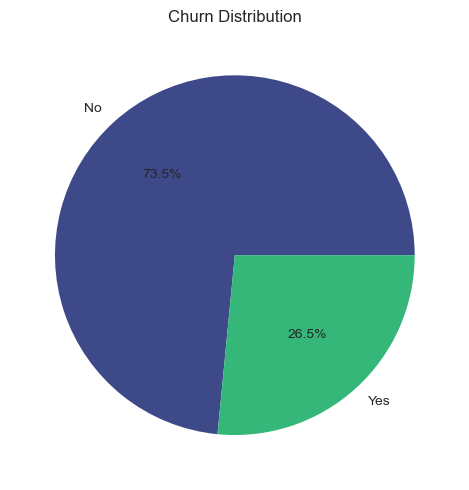

In [428]:
# Churn distribution
plt.figure(figsize=(8, 5))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=['No', 'Yes'], autopct='%1.1f%%', colors=[colors[1], colors[5]])
plt.title('Churn Distribution')
plt.tight_layout()
plt.show()


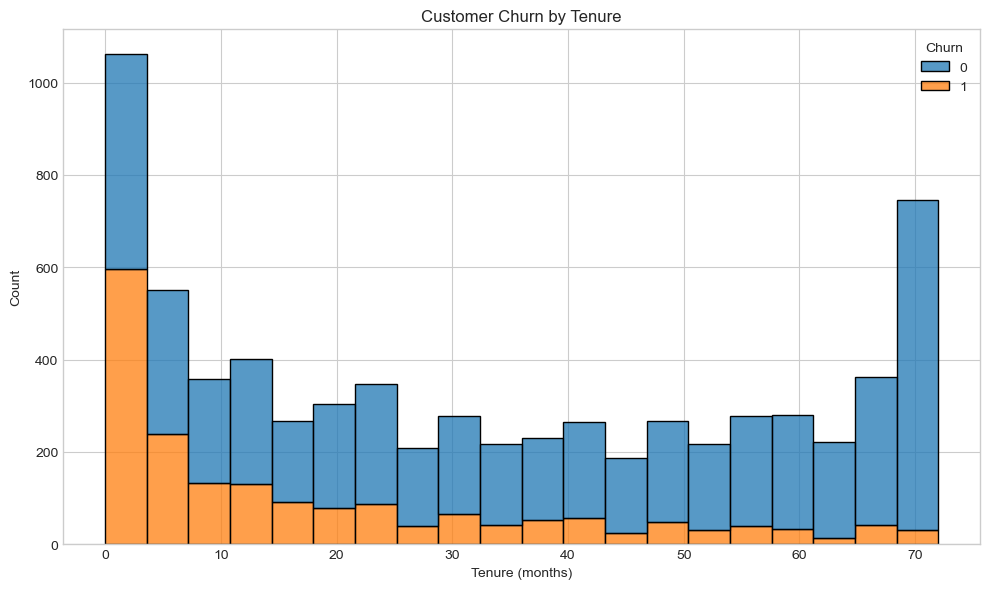

In [430]:
# Analyze churn by tenure
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', bins=20, multiple='stack')
plt.title('Customer Churn by Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

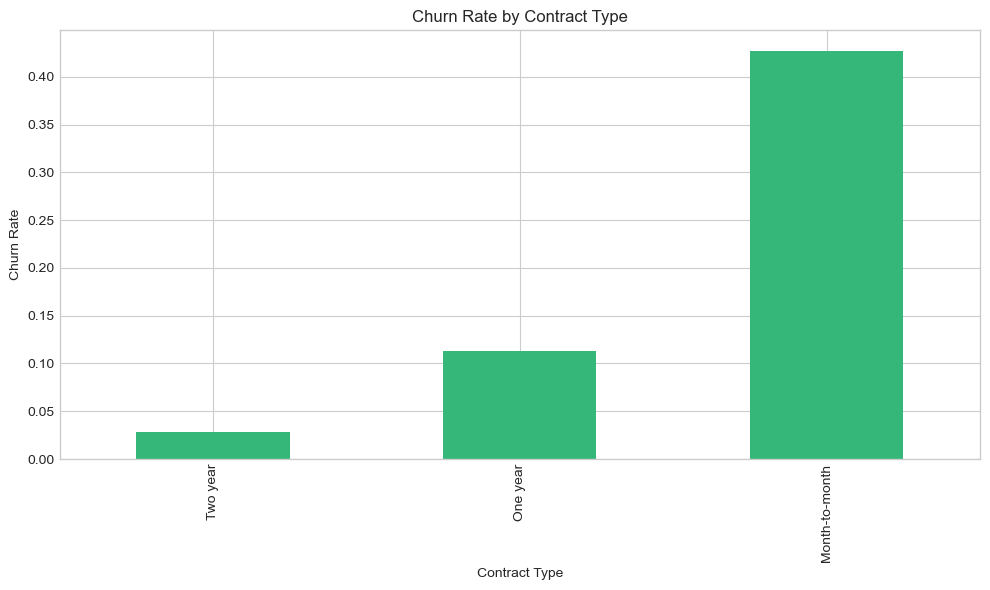

In [431]:
# Analyze churn by contract type
plt.figure(figsize=(10, 6))
contract_churn = pd.crosstab(df['Contract'], df['Churn'])
contract_churn_pct = contract_churn.div(contract_churn.sum(axis=1), axis=0)

# Use column index 1 instead of 'Yes' (since Churn is now 0/1)
contract_churn_pct[1].sort_values().plot(kind='bar', color=colors[5])
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.show()

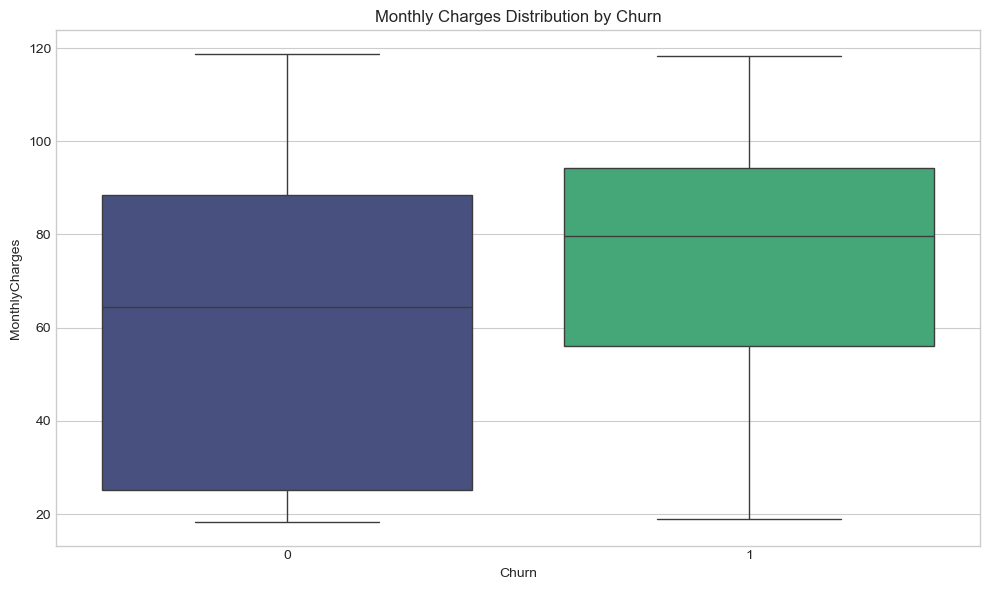

In [434]:
# Analyze monthly charges distribution by churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette=[colors[1], colors[5]])
plt.title('Monthly Charges Distribution by Churn')
plt.tight_layout()
plt.show()

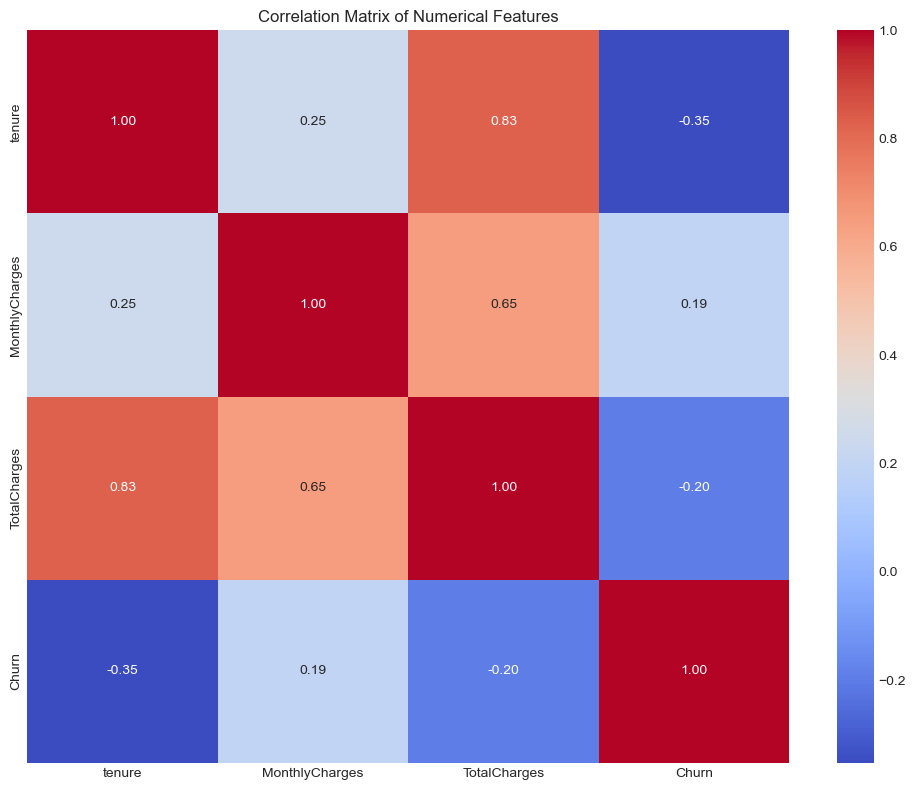

In [436]:

# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
correlation = df[numerical_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [438]:
# Analyze categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'customerID' in categorical_features:
    categorical_features.remove('customerID')  # Remove ID column


In [440]:
# Handle the case where 'Churn' might be object or already converted to int
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')  # Remove target column

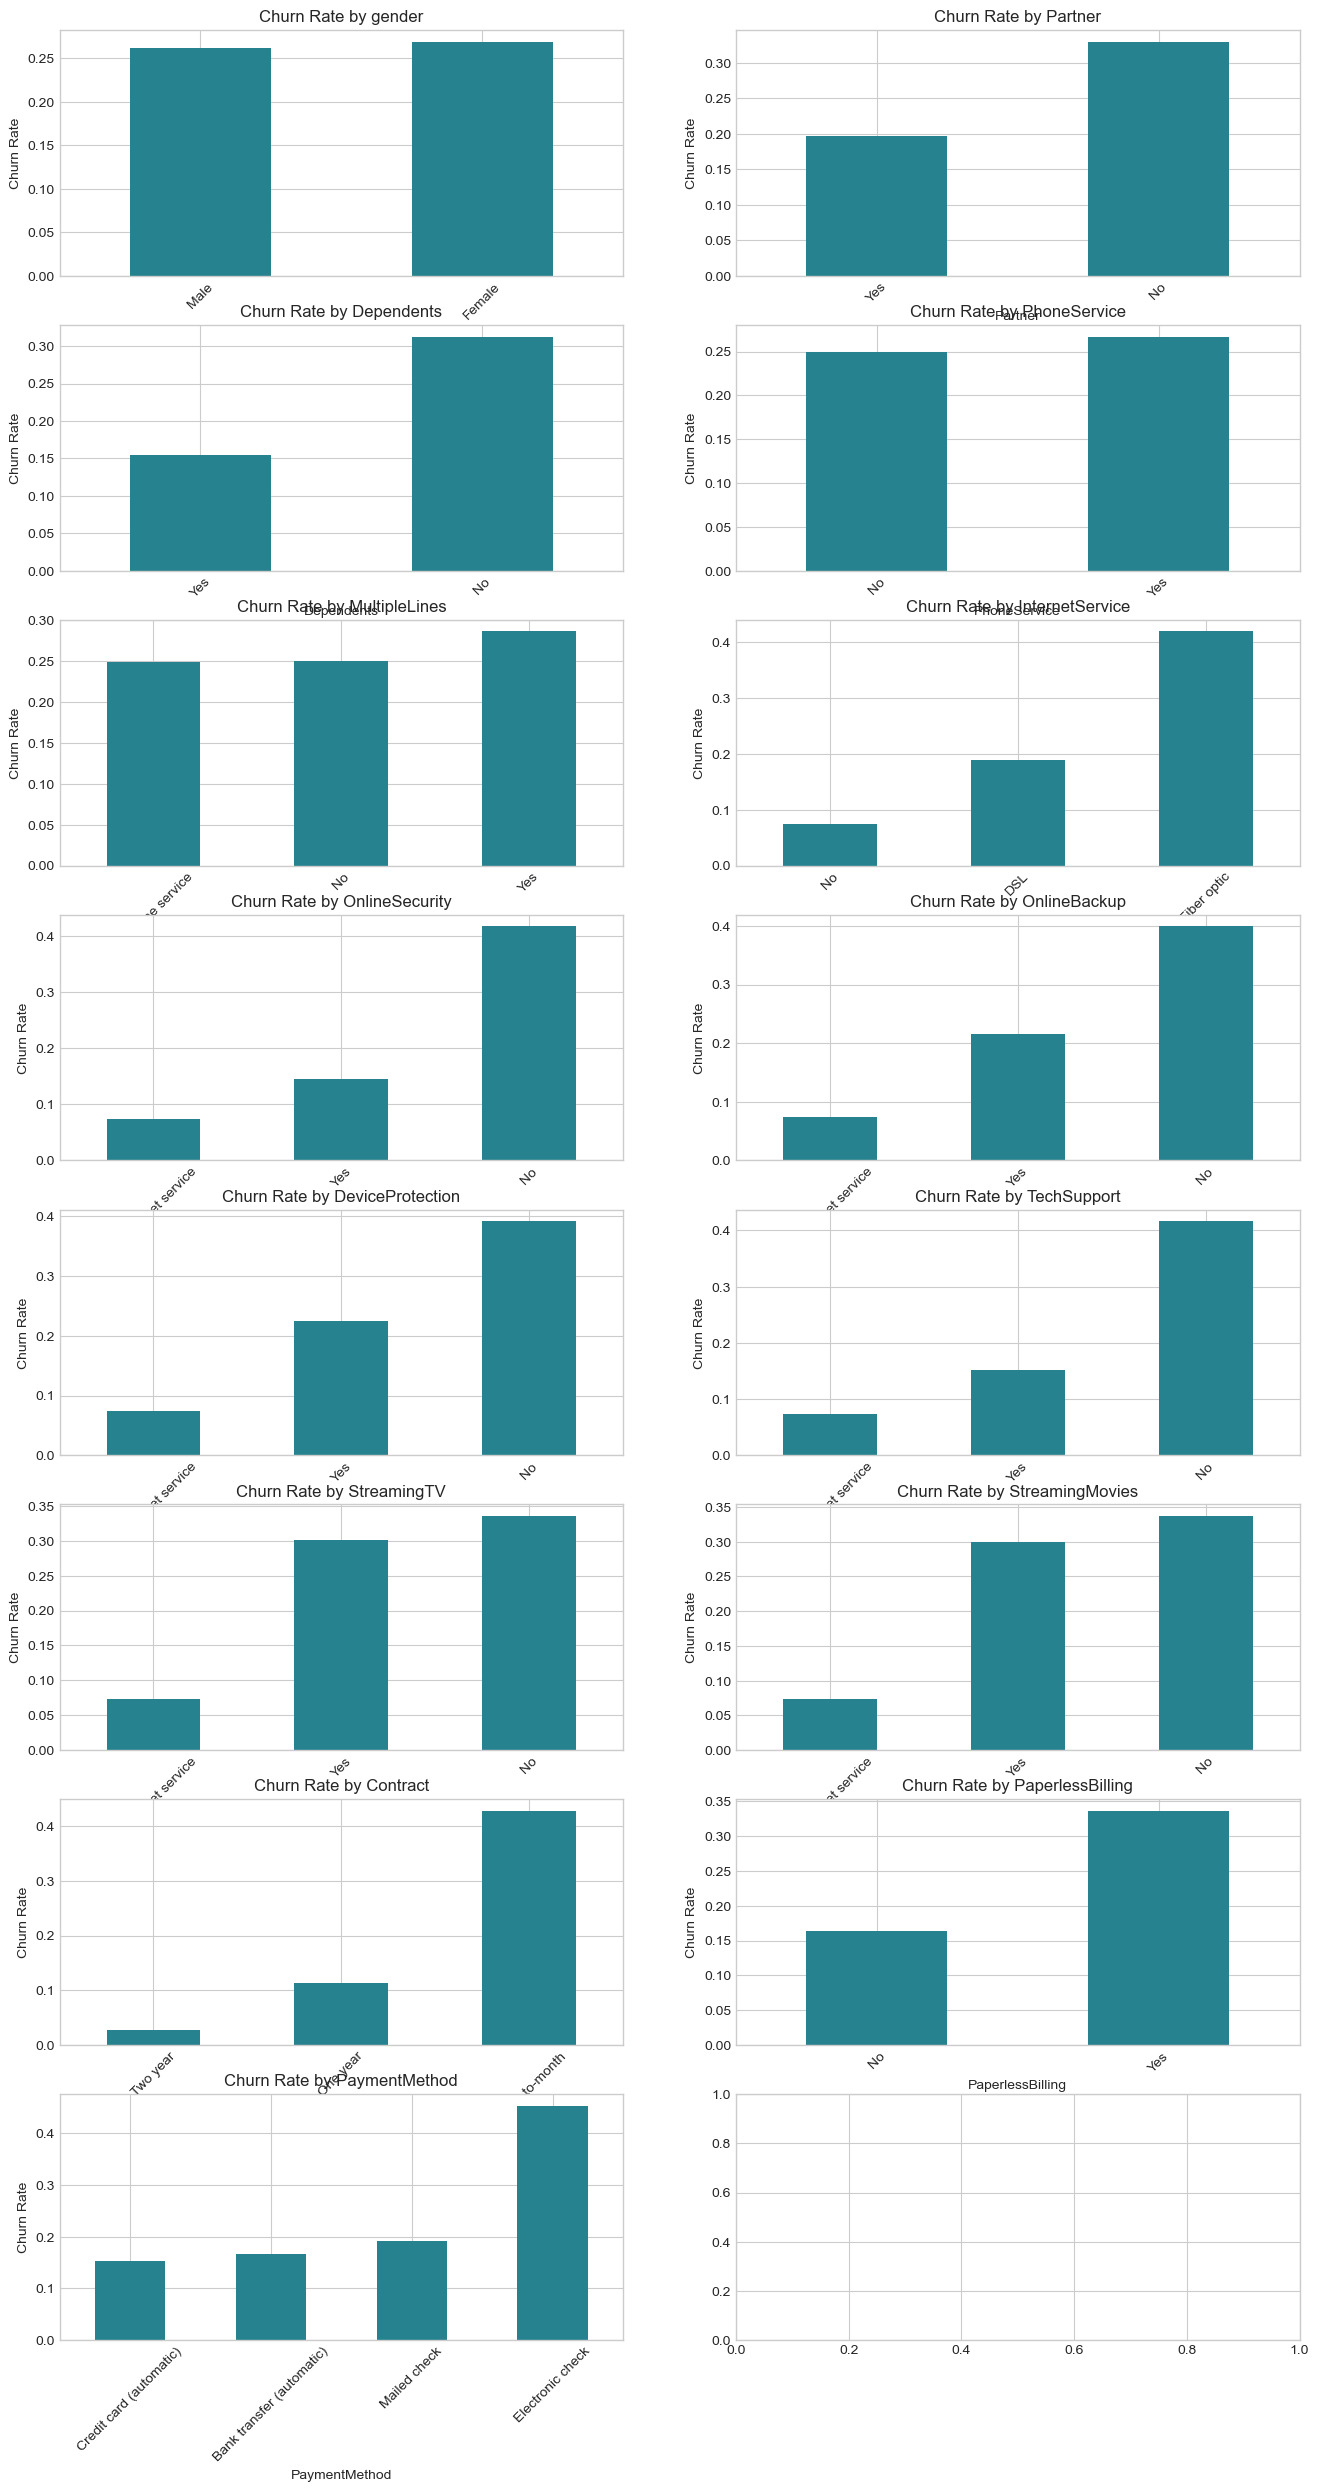

In [442]:
# Create subplot grid for categorical features
n_features = len(categorical_features)
fig, axes = plt.subplots(nrows=(n_features+1)//2, ncols=2, figsize=(16, n_features*2))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    feature_churn = pd.crosstab(df[feature], df['Churn'])
    feature_churn_pct = feature_churn.div(feature_churn.sum(axis=1), axis=0)
    
    # Handle either numeric or string representation of churn
    if 'Yes' in feature_churn_pct.columns:
        churn_col = 'Yes'
    else:
        churn_col = 1
    
    feature_churn_pct[churn_col].sort_values().plot(kind='bar', ax=axes[i], color=colors[3])
    axes[i].set_title(f'Churn Rate by {feature}')
    axes[i].set_ylabel('Churn Rate')
    axes[i].tick_params(axis='x', rotation=45)

In [443]:
# Handle case where there are more subplots than features
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Churn Rate Analysis by Categorical Features', fontsize=16)
plt.show()


<Figure size 640x480 with 0 Axes>

In [444]:
# 3. Data Preprocessing
# ====================

# Remove customer ID as it's not a predictor
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Check if Churn is already numeric
if df['Churn'].dtype == 'object':
    # Convert target variable to binary
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [445]:
# Handle categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Churn' in numerical_features:
    numerical_features.remove('Churn')  # Remove target from features

# Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [446]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [447]:
# 4. Model Building and Evaluation
# ===============================

# Define a function to evaluate models without MLflow
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    

In [454]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    with mlflow.start_run(run_name=model_name):
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Log parameters
        for param_name, param_value in model.get_params().items():
            mlflow.log_param(param_name, param_value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("roc_auc", roc_auc)
        
        # Log model
        mlflow.sklearn.log_model(model, f"{model_name}")
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n{model_name} Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        return model, accuracy, precision, recall, f1, roc_auc

2025/04/10 12:59:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


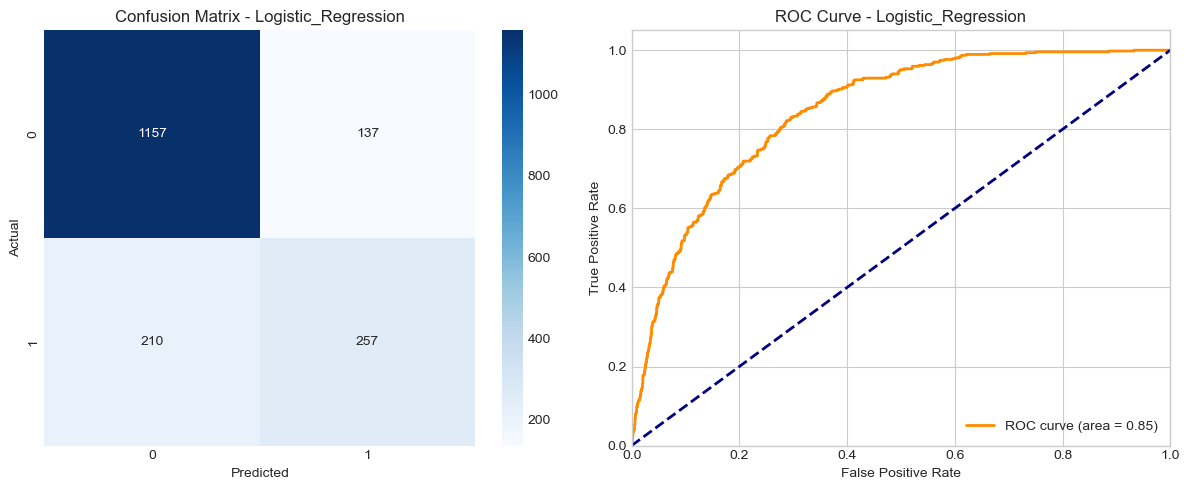


Logistic_Regression Performance:
Accuracy: 0.8030
Precision: 0.6523
Recall: 0.5503
F1 Score: 0.5970
ROC AUC: 0.8456

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1294
           1       0.65      0.55      0.60       467

    accuracy                           0.80      1761
   macro avg       0.75      0.72      0.73      1761
weighted avg       0.79      0.80      0.80      1761



2025/04/10 12:59:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


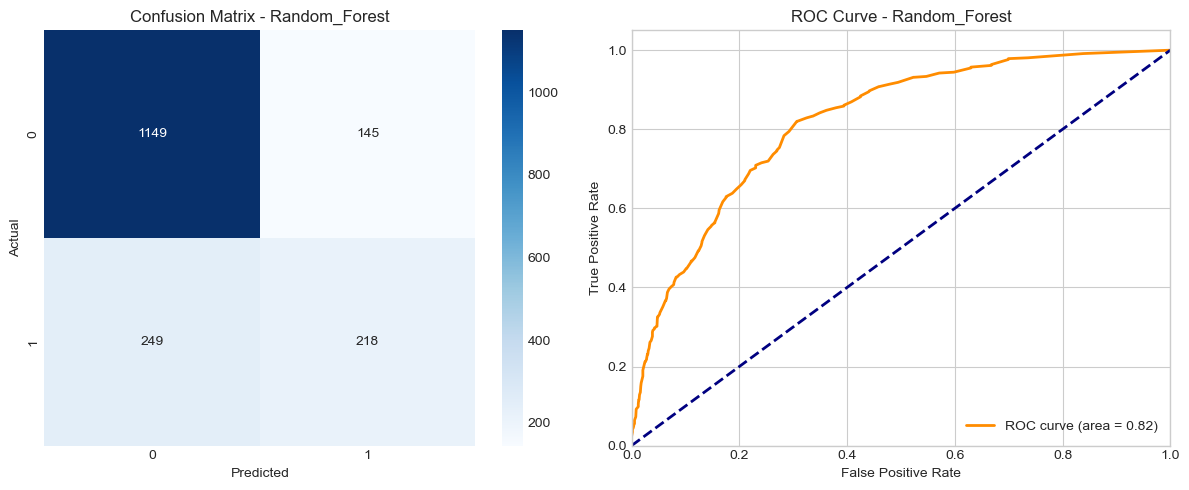


Random_Forest Performance:
Accuracy: 0.7763
Precision: 0.6006
Recall: 0.4668
F1 Score: 0.5253
ROC AUC: 0.8187

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1294
           1       0.60      0.47      0.53       467

    accuracy                           0.78      1761
   macro avg       0.71      0.68      0.69      1761
weighted avg       0.76      0.78      0.77      1761



In [456]:
# 4.1 Logistic Regression Model
# -----------------------------
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_model, lr_accuracy, lr_precision, lr_recall, lr_f1, lr_roc_auc = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "Logistic_Regression")

# 4.2 Random Forest Model
# ----------------------
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_model, rf_accuracy, rf_precision, rf_recall, rf_f1, rf_roc_auc = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random_Forest")


2025/04/10 12:59:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


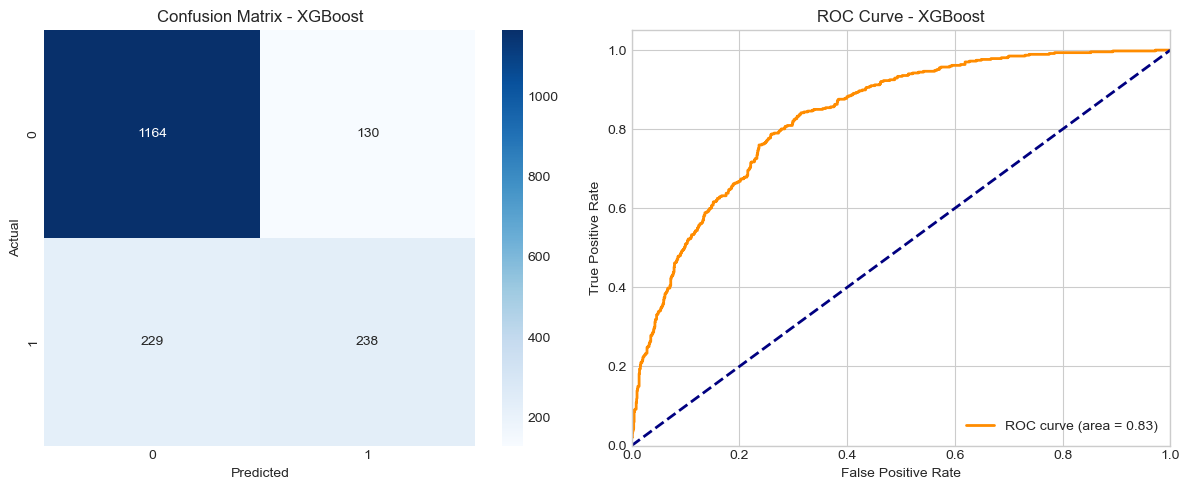


XGBoost Performance:
Accuracy: 0.7961
Precision: 0.6467
Recall: 0.5096
F1 Score: 0.5701
ROC AUC: 0.8338

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1294
           1       0.65      0.51      0.57       467

    accuracy                           0.80      1761
   macro avg       0.74      0.70      0.72      1761
weighted avg       0.79      0.80      0.79      1761



In [457]:
# 4.3 XGBoost Model
# ----------------
try:
    xgb_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
    ])

    xgb_model, xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_roc_auc = evaluate_model(
        xgb_model, X_train, X_test, y_train, y_test, "XGBoost")
    
    xgb_available = True
except (ImportError, NameError):
    print("XGBoost not available. Skipping XGBoost model.")
    xgb_available = False

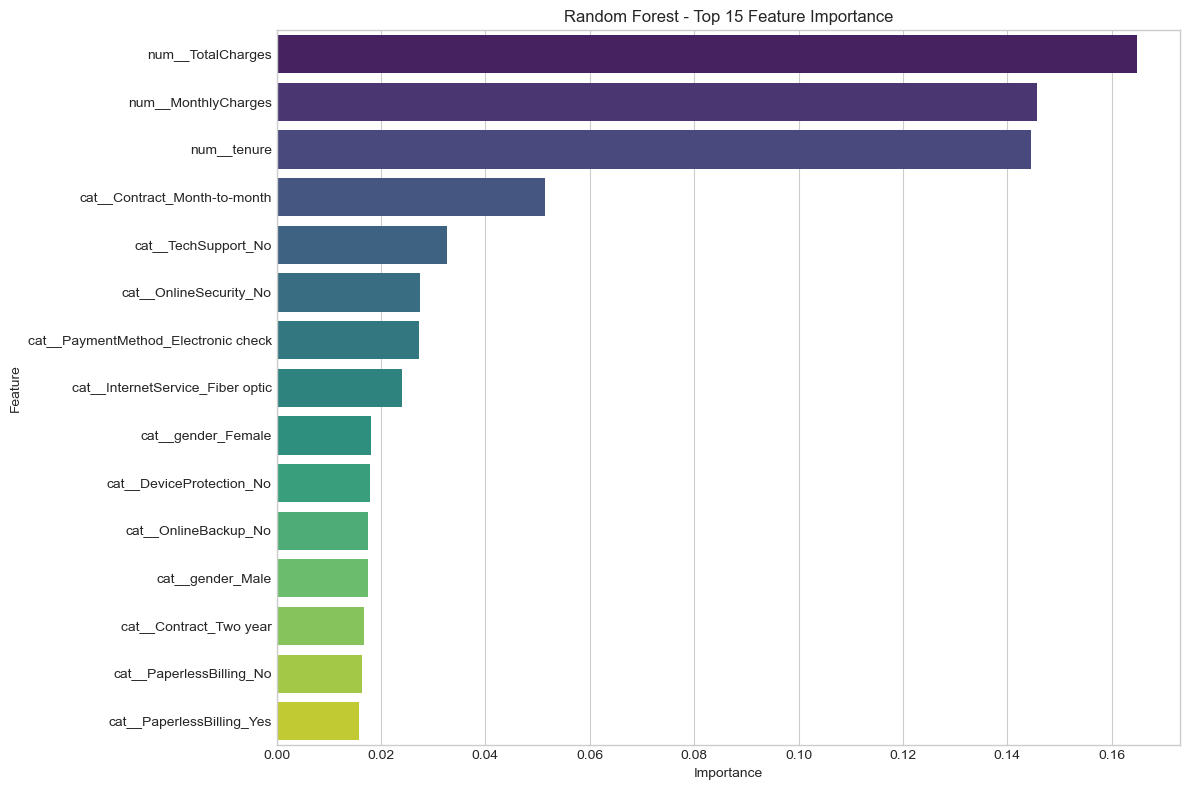

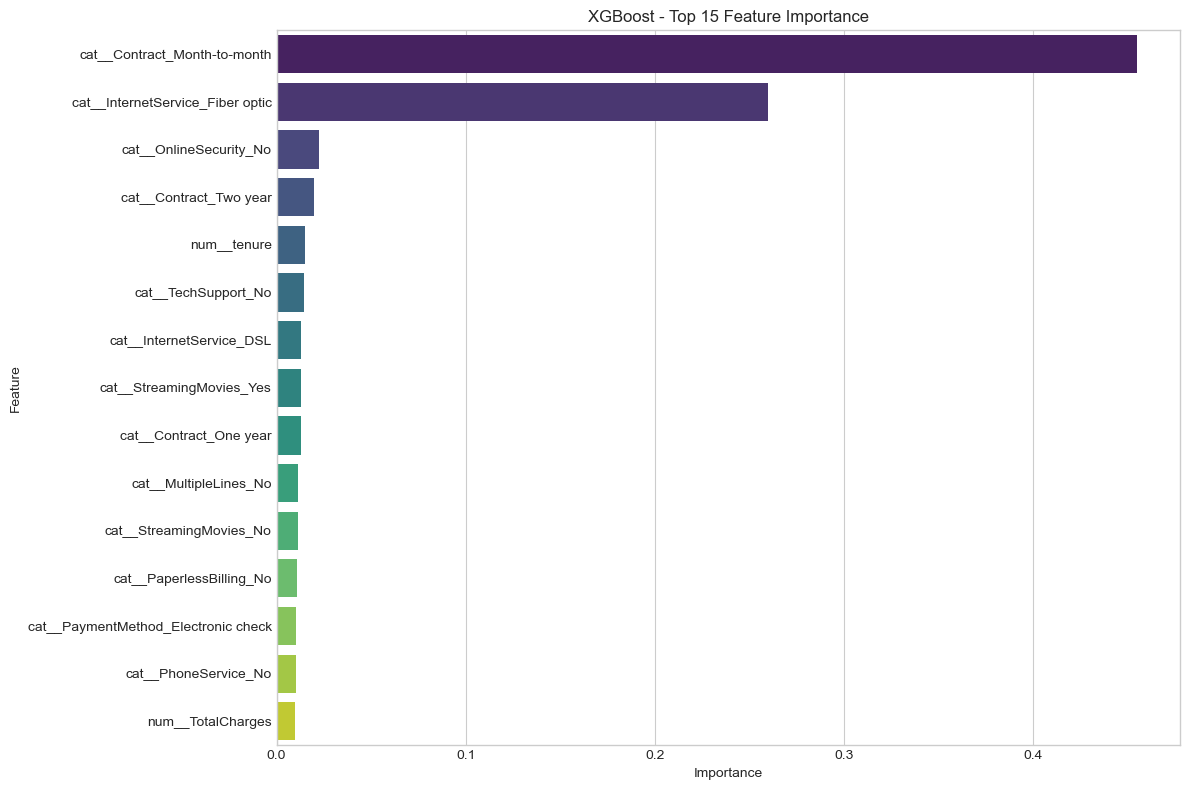

In [458]:
# 5. Feature Importance Analysis
# =============================

# Function to safely get feature names for different scikit-learn versions
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    try:
        # For sklearn >= 1.0
        return column_transformer.get_feature_names_out()
    except AttributeError:
        # For sklearn < 1.0
        output_features = []
        for name, trans, cols in column_transformer.transformers_:
            if name != 'remainder':
                if isinstance(cols, slice):
                    # Get feature names for slice
                    idxs = np.arange(X_train.shape[1])[cols]
                    output_features.extend([X_train.columns[i] for i in idxs])
                else:
                    # Get feature names for column indices or names
                    output_features.extend([X_train.columns[i] if isinstance(i, int) else i for i in cols])
        return output_features

try:
    # Get feature names after preprocessing
    preprocessor.fit(X_train)
    
    try:
        # Attempt to get feature names directly from the preprocessor
        feature_names = preprocessor.get_feature_names_out()
    except:
        # Fall back to manually constructing feature names
        feature_names = []
        
        # Get numerical feature names directly
        feature_names.extend(numerical_features)
        
        # Get one-hot encoded feature names safely
        try:
            categorical_features_encoded = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
            feature_names.extend(categorical_features_encoded)
        except:
            # For older versions of sklearn or if the above fails
            for feature in categorical_features:
                unique_values = X_train[feature].unique()
                for value in unique_values:
                    feature_names.append(f"{feature}_{value}")
    
    # For Random Forest model
    rf_classifier = rf_model.named_steps['classifier']
    rf_feature_importance = rf_classifier.feature_importances_
    
    # Make sure lengths match
    if len(rf_feature_importance) == len(feature_names):
        # Plot feature importance for Random Forest
        plt.figure(figsize=(12, 8))
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': rf_feature_importance
        }).sort_values('Importance', ascending=False).head(15)
        
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title('Random Forest - Top 15 Feature Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature names length ({len(feature_names)}) does not match importance vector length ({len(rf_feature_importance)}). Skipping plot.")
    
    # For XGBoost model
    if xgb_available:
        xgb_classifier = xgb_model.named_steps['classifier']
        xgb_feature_importance = xgb_classifier.feature_importances_
        
        # Make sure lengths match
        if len(xgb_feature_importance) == len(feature_names):
            # Plot feature importance for XGBoost
            plt.figure(figsize=(12, 8))
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': xgb_feature_importance
            }).sort_values('Importance', ascending=False).head(15)
            
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
            plt.title('XGBoost - Top 15 Feature Importance')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Feature names length ({len(feature_names)}) does not match importance vector length ({len(xgb_feature_importance)}). Skipping plot.")
except Exception as e:
    print(f"An error occurred during feature importance analysis: {e}")
    print("Skipping feature importance plots.")

In [459]:
# 6. Model Comparison
# ==================

# Create a dataframe for model comparison
model_data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1 Score': [lr_f1, rf_f1],
    'ROC AUC': [lr_roc_auc, rf_roc_auc]
}


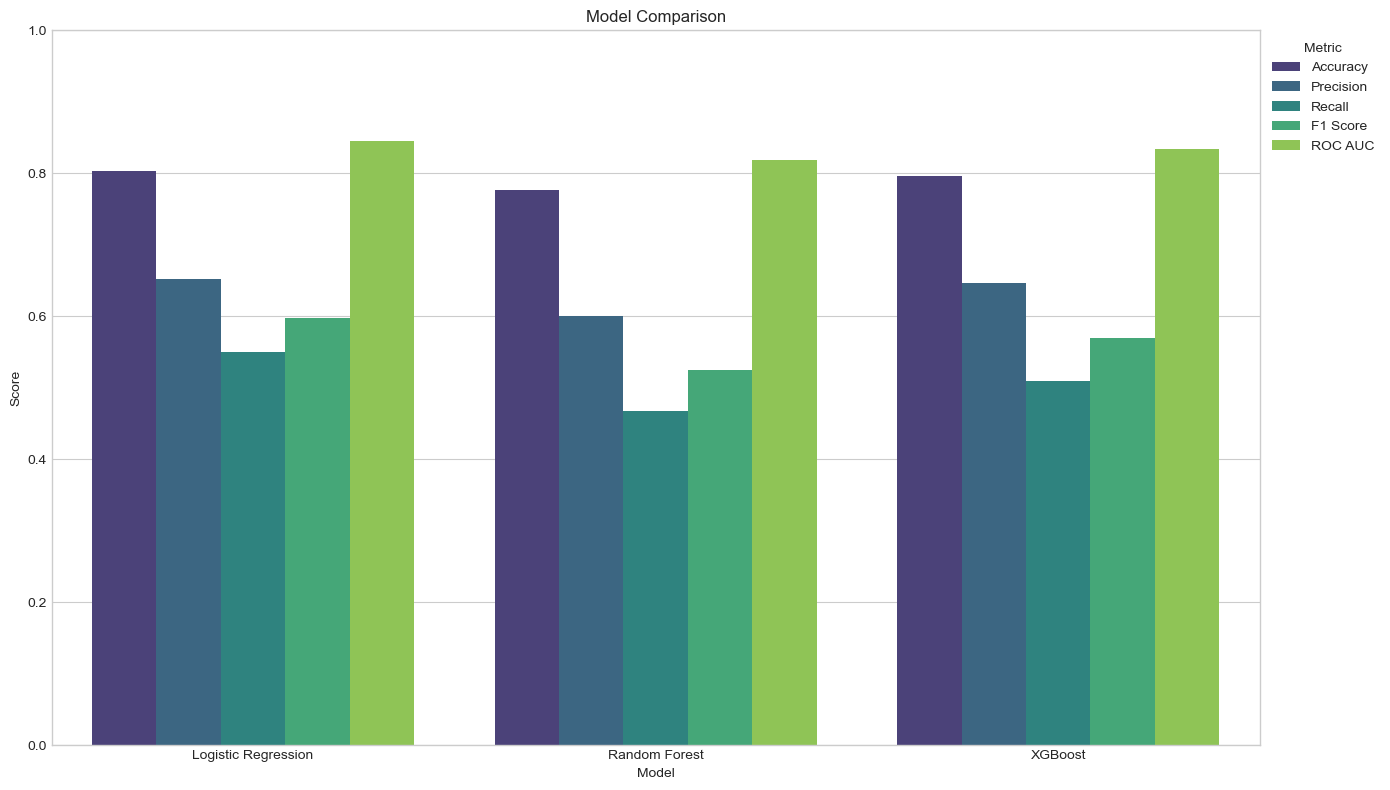

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.802953   0.652284  0.550321  0.596980  0.845588
1        Random Forest  0.776263   0.600551  0.466809  0.525301  0.818681
2              XGBoost  0.796139   0.646739  0.509636  0.570060  0.833818


In [460]:
# Add XGBoost results if available
if xgb_available:
    for key in model_data:
        if key == 'Model':
            model_data[key].append('XGBoost')
        elif key == 'Accuracy':
            model_data[key].append(xgb_accuracy)
        elif key == 'Precision':
            model_data[key].append(xgb_precision)
        elif key == 'Recall':
            model_data[key].append(xgb_recall)
        elif key == 'F1 Score':
            model_data[key].append(xgb_f1)
        elif key == 'ROC AUC':
            model_data[key].append(xgb_roc_auc)

model_comparison = pd.DataFrame(model_data)

# Plot model comparison
plt.figure(figsize=(14, 8))
model_comparison_melted = pd.melt(model_comparison, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=model_comparison_melted, palette='viridis')
plt.title('Model Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Metric', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

print(model_comparison)

Starting hyperparameter tuning for XGBoost...


2025/04/10 12:59:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


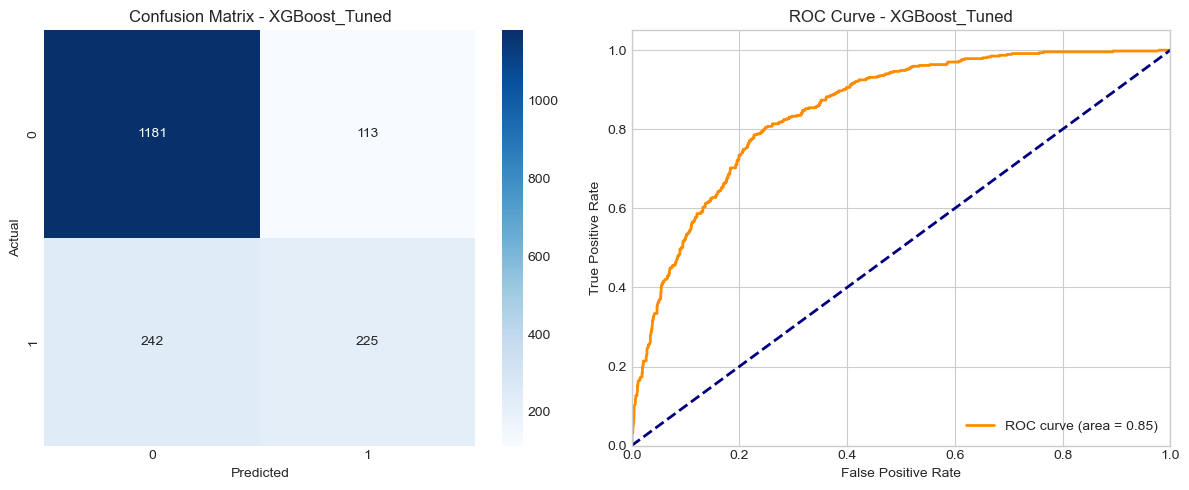


XGBoost_Tuned Performance:
Accuracy: 0.7984
Precision: 0.6657
Recall: 0.4818
F1 Score: 0.5590
ROC AUC: 0.8483

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1294
           1       0.67      0.48      0.56       467

    accuracy                           0.80      1761
   macro avg       0.75      0.70      0.71      1761
weighted avg       0.79      0.80      0.79      1761

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best Cross-Validation Score: 0.8471053258271795


In [461]:
# 7. Hyperparameter Tuning for Best Model
# ======================================

if xgb_available:
    # Based on the previous results, let's tune the XGBoost model
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    }

    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    print("Starting hyperparameter tuning for XGBoost...")
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Evaluate best model
    best_model, best_accuracy, best_precision, best_recall, best_f1, best_roc_auc = evaluate_model(
        best_model, X_train, X_test, y_train, y_test, "XGBoost_Tuned")
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)
else:
    # Tune Random Forest instead if XGBoost is not available
    print("XGBoost not available. Tuning Random Forest instead...")
    param_grid = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(
        rf_model,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Evaluate best model
    best_model, best_accuracy, best_precision, best_recall, best_f1, best_roc_auc = evaluate_model(
        best_model, X_train, X_test, y_train, y_test, "RandomForest_Tuned")
    
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

In [462]:
# 8. Save Final Model
# ==================

# Create directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model
import joblib
model_filename = 'models/churnguard_best_model.pkl'
joblib.dump(best_model, model_filename)

print(f"Model exploration completed and best model saved to {model_filename}!")

Model exploration completed and best model saved to models/churnguard_best_model.pkl!
